(1455, 410)
(1455,)
(1459, 410)
(1455, 410)
(1455,)
num of splits
10
Creating train and test sets for blending.
0 LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv=None, eps=0.001,
    fit_intercept=True, max_iter=50000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)
Fold 0
0.0209963903356
Fold 1
0.0116631526949
Fold 2
0.00990000133189
Fold 3
0.00880866470327
Fold 4
0.00580959823747
Fold 5
0.0128259499333
Fold 6
0.00810335648432
Fold 7
0.00706600342476
Fold 8
0.0271255459747
Fold 9
0.0067780697372
1 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Fold 0
0.019030326748
Fold 1
0.0115976137627
Fold 2
0.00979837980725
Fold 3
0.00879459519798
Fold 4
0.00581377103375
Fold 5
0.01286034918
Fold 6
0.00820537993666
Fold 7

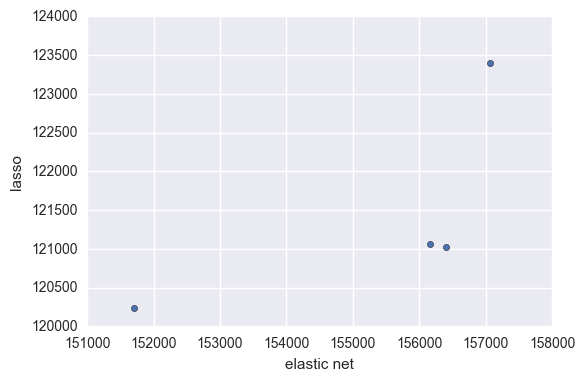

In [48]:
# %load blend.py
"""
BSD License, 3 clauses.

"""
import numpy as np
import pandas as pd
import load_data
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline





def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

if __name__ == '__main__':

    np.random.seed(0)  # seed to shuffle the train set

    n_folds = 10
    shuffle = False

    X, y, X_submission, Id = load_data.load()

    if shuffle:
        idx = np.random.permutation(y.size)
        X = X[idx]
        y = y[idx]
    print X.shape
    print y.shape

    
    skf = StratifiedKFold(y, n_folds=n_folds)
    print 'num of splits'
    print len(skf) 


    clfs = [ LassoCV(alphas = [1,0.1, 0.001, 0.0005], max_iter=50000),
            ElasticNet(alpha=0.001, l1_ratio=0.5),
            BayesianRidge(),
            xgb.XGBRegressor(n_estimators=360, learning_rate=0.1, max_depth=2, min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.6),
            # ExtraTreesRegressor(n_estimators=400, max_depth=60),
            # RandomForestRegressor(n_estimators=400, max_depth=50)
            ]

    print "Creating train and test sets for blending."

    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))
    model_error = np.zeros(len(clfs))

    X=X.values
    y=y.values
    X_submission=X_submission.values

    for j, clf in enumerate(clfs):
        print j, clf
        dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
        model_error_j = np.zeros(len(skf))
        for i, (train_ind, test_ind) in enumerate(skf):
            print "Fold", i
            X_train = X[train_ind]
            y_train = y[train_ind]
            X_test = X[test_ind]
            y_test = y[test_ind]
            clf.fit(X_train, y_train)
            y_submission = clf.predict(X_test)
            print mean_squared_error(y_submission, y_test)
            model_error_j[i] = mean_squared_error(y_submission, y_test)
            dataset_blend_train[test_ind, j] = y_submission
            dataset_blend_test_j[:, i] = clf.predict(X_submission)
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
        model_error[j] = model_error_j.mean()

    print
    print "Blending."
    # clf = RidgeCV(alphas=(0.1, 1.0, 10.0))
    clf = LinearRegression()
    clf.fit(dataset_blend_train, y)
    y_submission = clf.predict(dataset_blend_test)
    
    print "rescale to original one"
    y_submission = np.expm1(y_submission)
   
    print "Saving Results."
    solution = pd.DataFrame({"id":Id, "SalePrice":y_submission})
    solution.to_csv("stacking.csv", index= False)


    print "error {}".format(model_error)
    model_error = 1./model_error 
    inverse_model_error = model_error / sum(model_error)
    print "weights of models {} (inverse error)".format(inverse_model_error)

    print "rescale to original one"
    dataset_blend_test = np.expm1(dataset_blend_test)

    #find the outlier of lasso use other method to replace it
    # index = dataset_blend_test[0].argmax(axis=0)
    # print "original lasso predict val {}".format(dataset_blend_test[0][index])
    # print "change to elastic net val{}".format(dataset_blend_test[1][index])
    # dataset_blend_test[0][index] = dataset_blend_test[1][index]

    predictions = pd.DataFrame({"elastic net": dataset_blend_test[1], "lasso":dataset_blend_test[0]})
    predictions.plot(x= "elastic net", y = "lasso", kind = "scatter")



    y_submission = np.sum(dataset_blend_test * inverse_model_error, axis=1)
    print y_submission
    
    # print "rescale to original one"
    # y_submission = np.expm1(y_submission)

   
    print "Saving Results."
    solution = pd.DataFrame({"id":Id, "SalePrice":y_submission})
    solution.to_csv("weighted_blend.csv", index= False)



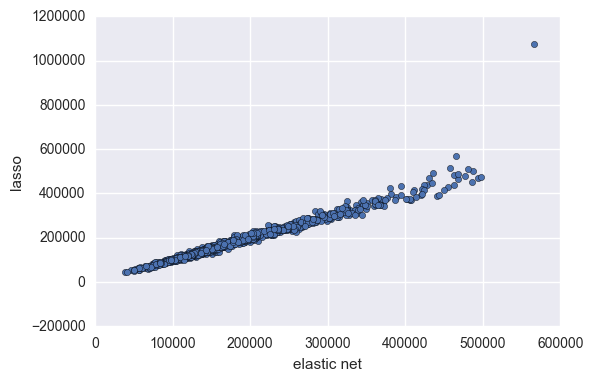

In [56]:

predictions = pd.DataFrame({"elastic net": dataset_blend_test.T[3], "lasso":dataset_blend_test.T[0]})
predictions.plot(x= "elastic net", y = "lasso", kind = "scatter")

In [71]:
second_max = sorted(set(y_submission))[-2]
print second_max
print y_submission.argmax(axis=0)
# [y_submission[y_submission.argmax(axis=0)] = second_max
# ]max(y_submission)
print np.expm1([max(y)])

503131.935129
514
[ 625000.]
